In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from astropy.stats import LombScargle

from maelstrom.maelstrom import Maelstrom
from maelstrom.estimator import estimate_frequencies

/Users/sjm/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [23]:
kicid = 11754974
# kicid = 9837267

data = np.loadtxt("data/kic{0}_lc.txt".format(kicid))
fulltimes = data[:, 0] # days
tmid = 0.5*(fulltimes[0] + fulltimes[-1])
times = fulltimes - tmid
dmmags = data[:, 1] * 1000. # mmags

# times = times[2500:]
# dmmags = dmmags[2500:]

metadata = np.loadtxt("data/kic{0}_metadata.csv".format(kicid), delimiter=",", skiprows=1)
nu_arr = metadata[::6]

orbits = pd.read_csv("data/orbits.csv").rename(columns = lambda x: x.strip())

orb_params = orbits[orbits.Name == "kic{0}".format(kicid)].iloc[0]
porb = orb_params.Porb
a1 = orb_params["a1sini/c"]
tp = orb_params["t_p"] - tmid
e = orb_params["e"]
varpi = orb_params["varpi"]
a1d = a1/86400.0

In [25]:
model = Maelstrom(times, dmmags, nu_arr)
model.init_from_orbit(period=porb, lighttime=a1d, tref=tp, eccen=e, varpi=varpi)

In [26]:
model.get_session().run(model.chi2)

4934940.6300498974

In [27]:
model.optimize([model.nu])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 4889684.431596
  Number of iterations: 9
  Number of functions evaluations: 16


In [28]:
model.optimize([model.period, model.tref])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 4889667.160893
  Number of iterations: 2
  Number of functions evaluations: 5


In [29]:
model.optimize([model.period, model.tref, model.lighttime])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 4889593.095279
  Number of iterations: 5
  Number of functions evaluations: 8


In [30]:
model.get_lighttime_estimates()

[array([ 0.00151217,  0.00147329]),
 array([  4.00492869e+11,   3.09504063e+10])]

In [31]:
model.pin_lighttime_values()

(array([0, 0], dtype=int32), array([ 0.00150938]))

In [32]:
model.get_lighttime_estimates()

[array([ 0.00150938,  0.00150938]),
 array([  4.00492631e+11,   3.09494374e+10])]

In [33]:
model.optimize([model.eccen_param, model.varpi])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 4889595.449878
  Number of iterations: 14
  Number of functions evaluations: 17


In [34]:
model.optimize([model.period, model.log_sigma2, model.tref, model.lighttime, model.eccen_param, model.varpi])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 282509.667916
  Number of iterations: 21
  Number of functions evaluations: 29


In [35]:
model.optimize([model.nu])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 282509.663836
  Number of iterations: 2
  Number of functions evaluations: 6


In [36]:
model.nu_data - model.get_session().run(model.nu)

array([  9.73600124e-06,   1.28748290e-05])

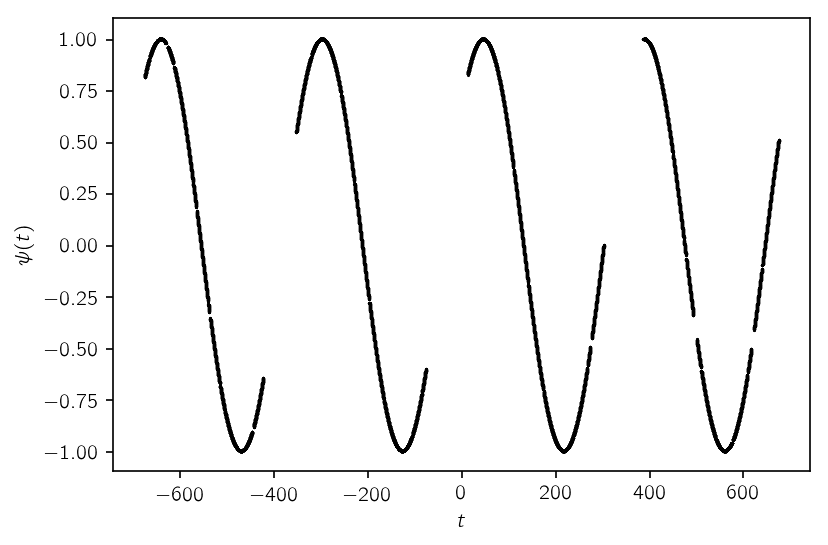

In [37]:
plt.plot(times, model.run(model.psi), ".k", ms=1)
plt.ylabel("$\psi(t)$")
plt.xlabel("$t$");

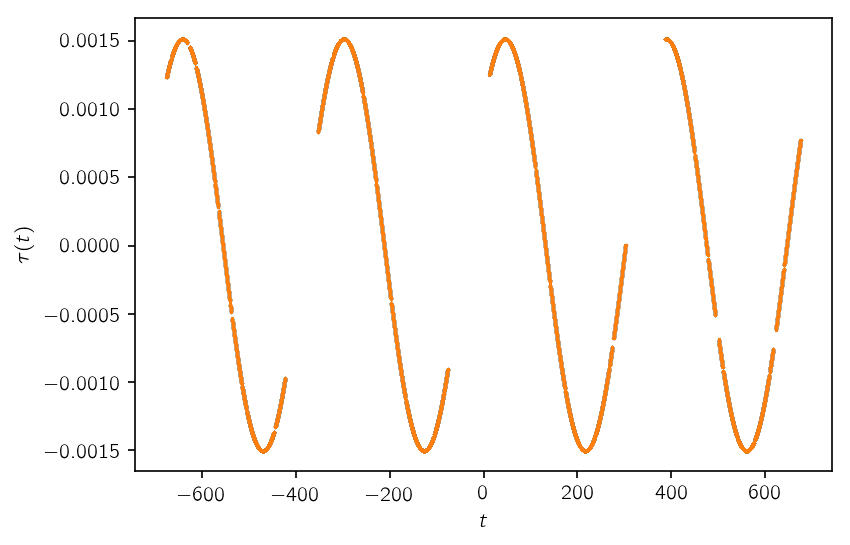

In [38]:
plt.plot(times, model.run(model.tau), ".", ms=1)
plt.ylabel(r"$\tau(t)$")
plt.xlabel("$t$");

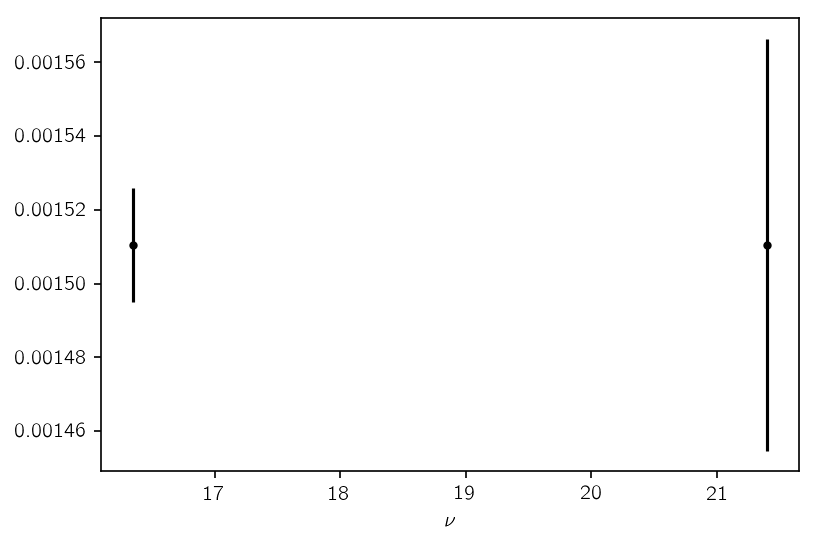

In [39]:
lt, lt_ivar = model.get_lighttime_estimates()
lt_err = np.sqrt(1./lt_ivar)
nu = model.run(model.nu)
plt.errorbar(nu, lt, yerr=lt_err, fmt="k.")
# plt.ylim(-0.01, 0.01)
plt.xlabel(r"$\nu$")

In [40]:
model.run([model.period, model.eccen, model.lighttime*86400.0])

[343.34996668553151,
 0.0055353191594573331,
 array([ 130.50664964,    0.        ])]

In [41]:
orb_params

Name                   kic11754974
Porb                       343.242
Porb_sig_p                0.500622
Porb_sig_m                0.497353
a1sini/c                   131.138
a1sini/c_sig_p             1.17293
a1sini/c_sig_m             1.18227
e                         0.018982
e_sig_p                   0.017421
e_sig_m                   0.011861
phip                      0.451625
phip_sig_p                0.132112
phip_sig_m                0.276224
varpi                     0.737616
varpi_sig_p               0.844385
varpi_sig_m                1.75724
f(M)Msun                 0.0205526
f(M)Msun_sig_p           0.0005547
f(M)Msun_sig_m           0.0005591
gradient                 -0.009368
grad_sig_p                0.002241
grad_sig_m                0.002392
t_p                        55113.4
t_p_sig_p                  45.3491
t_p_sig_m                  94.8129
K1_ms                       8328.6
K1_ms_sig_p                   48.6
K1_ms_sig_m                     46
median_segment_size 